# RQ2: Detection Metrics Analysis

This notebook evaluates the detection performance of security analysis tools (Bandit, Semgrep, AST) using ground truth labels.

**Evaluation Approach:**
- SecurityEval: Tools evaluated on detecting expected CWEs
- Manual: Tools evaluated on detecting any vulnerabilities (human-assessed)
- Metrics: Precision, Recall, F1-Score, Confusion Matrices

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set style for thesis-ready plots
plt.style.use('seaborn-v0_8-paper')
sns.set_palette('colorblind')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['legend.fontsize'] = 10

print("✓ Libraries imported")

✓ Libraries imported


## 1. Load Data and Define Predictions

### Evaluation Approach

**For SecurityEval Dataset:**
- **Prediction (TP)**: Tool detected the expected CWE at ANY point in workflow (`*_found_anywhere = True`)
- **Ground Truth (GT)**: Expected CWE was found at ANY point in workflow (`gt_vulnerable = True`)
- **Metrics**: Precision, Recall, F1-Score based on expected CWE detection across entire workflow
- **Note**: Additional CWEs detected are tracked separately but NOT counted as false positives

This approach evaluates whether tools can detect the specific targeted vulnerability in each test case, considering detection across all code iterations.

In [ ]:
# Load labeled evaluation data
data_path = Path('data/evaluation_labeled.csv')

# Check if file exists
if not data_path.exists():
    print(" ERROR: evaluation_labeled.csv not found!")
    raise FileNotFoundError(f"Required file not found: {data_path}")

df = pd.read_csv(data_path)

print(f"✓ Loaded {len(df)} samples")
print(f"\nColumns: {list(df.columns)}")

print(f"\n" + "="*80)
print("GROUND TRUTH DISTRIBUTION")
print("="*80)

# Overall distribution
print(f"\nOverall:")
gt_counts = df['gt_vulnerable'].value_counts()
print(f"  Vulnerable: {gt_counts.get(True, 0)}")
print(f"  Not Vulnerable: {gt_counts.get(False, 0)}")

# By prompt type
if 'prompt_type' in df.columns:
    print(f"\nBy Dataset Type:")
    for prompt_type in df['prompt_type'].unique():
        subset = df[df['prompt_type'] == prompt_type]
        vulnerable = subset['gt_vulnerable'].sum()
        not_vulnerable = len(subset) - vulnerable
        print(f"  {prompt_type} (n={len(subset)}):")
        print(f"    - Vulnerable: {vulnerable} ({vulnerable/len(subset)*100:.1f}%)")
        print(f"    - Not Vulnerable: {not_vulnerable} ({not_vulnerable/len(subset)*100:.1f}%)")
else:
    print("\n⚠️  'prompt_type' column not found - cannot show stratified distribution")

print("="*80)

✓ Loaded 84 samples

Columns: ['workflow_id', 'workflow', 'timestamp', 'file', 'source_file', 'prompt_type', 'prompt', 'llm_response', 'vulnerabilities_found', 'total_vulnerabilities_identified', 'total_vulnerabilities_fixed', 'total_vulnerabilities_remaining', 'initial_detection_bandit_count', 'initial_detection_bandit_cwes', 'initial_detection_semgrep_count', 'initial_detection_semgrep_cwes', 'initial_detection_ast_count', 'initial_detection_ast_cwes', 'iteration_detection_bandit_count', 'iteration_detection_bandit_cwes', 'iteration_detection_semgrep_count', 'iteration_detection_semgrep_cwes', 'iteration_detection_ast_count', 'iteration_detection_ast_cwes', 'iterations_count', 'fixed_cwes', 'remaining_cwes', 'fix_provider_llm', 'fix_provider_rule_based', 'fix_provider_unknown', 'fix_provider_llm_cwes', 'fix_provider_rule_cwes', 'fix_provider_unknown_cwes', 'unique_cwes_fixed', 'unique_cwes_remaining', 'unique_cwes_identified', 'gt_vulnerable', 'gt_cwes', 'gt_source', 'expected_cwe', 

### Understanding Manual Dataset Ground Truth

**Important distinction for Manual workflows:**
- **Ground Truth (gt_vulnerable)**: Based on **human expert assessment** from `manual_human_labels.csv`
  - 21 workflows were assessed by humans as containing vulnerabilities
  - 21 workflows were assessed by humans as NOT containing vulnerabilities
  
- **System Detection**: What the security tools actually detected
  - Of the 21 human-assessed-as-vulnerable workflows, only **13 had detections** (TP)
  - The remaining **8 had NO detections** (FN - tools missed these vulnerabilities)

The confusion matrix evaluates whether the **tools** can correctly identify what **humans identified** as vulnerable code.

In [3]:
# Show detailed breakdown for Manual dataset
if 'prompt_type' in df.columns:
    manual_data = df[df['prompt_type'] == 'Manual']
    
    print("\n" + "="*80)
    print("MANUAL DATASET: GROUND TRUTH vs SYSTEM DETECTION BREAKDOWN")
    print("="*80)
    
    # Ground truth from human assessment
    gt_vulnerable_count = manual_data['gt_vulnerable'].sum()
    gt_not_vulnerable_count = len(manual_data) - gt_vulnerable_count
    
    print(f"\n1. GROUND TRUTH (from manual_human_labels.csv - Human Expert Assessment):")
    print(f"   - Human assessed as VULNERABLE: {gt_vulnerable_count} workflows")
    print(f"   - Human assessed as NOT vulnerable: {gt_not_vulnerable_count} workflows")
    
    # System detection
    if 'vulnerabilities_found' in df.columns:
        system_detected = (manual_data['vulnerabilities_found'] > 0).sum()
        system_not_detected = len(manual_data) - system_detected
        
        print(f"\n2. SYSTEM DETECTION (what security tools actually found):")
        print(f"   - System DETECTED vulnerabilities: {system_detected} workflows")
        print(f"   - System DID NOT detect vulnerabilities: {system_not_detected} workflows")
        
        # Cross-tabulation
        manual_vulnerable = manual_data[manual_data['gt_vulnerable'] == True]
        manual_not_vulnerable = manual_data[manual_data['gt_vulnerable'] == False]
        
        tp = (manual_vulnerable['vulnerabilities_found'] > 0).sum()
        fn = (manual_vulnerable['vulnerabilities_found'] == 0).sum()
        fp = (manual_not_vulnerable['vulnerabilities_found'] > 0).sum()
        tn = (manual_not_vulnerable['vulnerabilities_found'] == 0).sum()
        
        print(f"\n3. CONFUSION MATRIX BREAKDOWN:")
        print(f"   - True Positives (TP): {tp} [Human says YES, System detected YES]")
        print(f"   - False Negatives (FN): {fn} [Human says YES, System detected NO]")
        print(f"   - False Positives (FP): {fp} [Human says NO, System detected YES]")
        print(f"   - True Negatives (TN): {tn} [Human says NO, System detected NO]")
        
        print(f"\n4. KEY INSIGHT:")
        print(f"   → Ground truth = {gt_vulnerable_count} vulnerable workflows (HUMAN ASSESSMENT)")
        print(f"   → But only {tp} of them had system detections")
        print(f"   → The tools MISSED {fn} vulnerabilities that humans identified")
        
    print("="*80)


MANUAL DATASET: GROUND TRUTH vs SYSTEM DETECTION BREAKDOWN

1. GROUND TRUTH (from manual_human_labels.csv - Human Expert Assessment):
   - Human assessed as VULNERABLE: 21 workflows
   - Human assessed as NOT vulnerable: 21 workflows

2. SYSTEM DETECTION (what security tools actually found):
   - System DETECTED vulnerabilities: 13 workflows
   - System DID NOT detect vulnerabilities: 29 workflows

3. CONFUSION MATRIX BREAKDOWN:
   - True Positives (TP): 13 [Human says YES, System detected YES]
   - False Negatives (FN): 8 [Human says YES, System detected NO]
   - False Positives (FP): 0 [Human says NO, System detected YES]
   - True Negatives (TN): 21 [Human says NO, System detected NO]

4. KEY INSIGHT:
   → Ground truth = 21 vulnerable workflows (HUMAN ASSESSMENT)
   → But only 13 of them had system detections
   → The tools MISSED 8 vulnerabilities that humans identified


In [ ]:
# Define snippet-level predictions based on dataset type
# TWO DIFFERENT EVALUATION STRATEGIES:
# 1. SecurityEval: Predicted as vulnerable if tool detected the expected CWE (using *_found_anywhere)
# 2. Manual: Predicted as vulnerable if tool detected ANY vulnerability (vulnerabilities_found > 0)

print("="*80)
print("DEFINING PREDICTION LOGIC (Dataset-Specific)")
print("="*80)

# IMPORTANT: Redefine ground truth for SecurityEval
# Ground truth should be: Does this workflow have vulnerabilities?
# For SecurityEval: 
#   - If vulnerabilities_found == 0: Safe prompt (gt = False, should be TN)
#   - If vulnerabilities_found > 0: Unsafe prompt (gt = True, tool should detect expected CWE)
securityeval_mask = df['prompt_type'] == 'SecurityEval'

# For SecurityEval: Ground truth based on whether vulnerabilities exist in the workflow
if 'vulnerabilities_found' in df.columns:
    df.loc[securityeval_mask, 'gt'] = (df.loc[securityeval_mask, 'vulnerabilities_found'] > 0).astype(int)
else:
    # Fallback: use gt_vulnerable from notebook 03
    df.loc[securityeval_mask, 'gt'] = df.loc[securityeval_mask, 'gt_vulnerable'].astype(int)

# For Manual: Use existing gt_vulnerable from notebook 03 (human assessment)
manual_mask = df['prompt_type'] == 'Manual'
df.loc[manual_mask, 'gt'] = df.loc[manual_mask, 'gt_vulnerable'].astype(int)

print("  → Ground Truth: Workflows with vulnerabilities_found > 0 are unsafe (should detect expected CWE)")
print("  → Ground Truth: Workflows with vulnerabilities_found == 0 are safe (TN)")
print("  → Prediction: Tool detected the expected CWE ANYWHERE in workflow (using *_found_anywhere columns)")
print(f"\nManual workflows (n={manual_mask.sum()}):")
print("  → Ground Truth: Based on human expert assessment")
print("  → Prediction: Tool detected ANY vulnerability (using vulnerabilities_found > 0)")

# Show ground truth distribution
print(f"\nGround Truth Distribution:")
print(f"  SecurityEval vulnerable: {df.loc[securityeval_mask, 'gt'].sum()}/{securityeval_mask.sum()}")
print(f"  Manual vulnerable: {df.loc[manual_mask, 'gt'].sum()}/{manual_mask.sum()}")

# Initialize prediction columns
df['bandit_pred'] = 0
df['semgrep_pred'] = 0
df['ast_pred'] = 0
df['combined_pred'] = 0

# SecurityEval predictions: Use *_found_anywhere columns (detection across ALL iterations)
# This ensures predictions match ground truth (both consider entire workflow)
if 'bandit_found_anywhere' in df.columns:
    df.loc[securityeval_mask, 'bandit_pred'] = df.loc[securityeval_mask, 'bandit_found_anywhere'].astype(int)
else:
    # Fallback to initial detection if *_found_anywhere columns don't exist
    print("  WARNING: 'bandit_found_anywhere' column not found. Using 'bandit_matches_expected' (initial detection only)")
    df.loc[securityeval_mask, 'bandit_pred'] = df.loc[securityeval_mask, 'bandit_matches_expected'].astype(int)

if 'semgrep_found_anywhere' in df.columns:
    df.loc[securityeval_mask, 'semgrep_pred'] = df.loc[securityeval_mask, 'semgrep_found_anywhere'].astype(int)
else:
    print("  WARNING: 'semgrep_found_anywhere' column not found. Using 'semgrep_matches_expected' (initial detection only)")
    df.loc[securityeval_mask, 'semgrep_pred'] = df.loc[securityeval_mask, 'semgrep_matches_expected'].astype(int)

if 'ast_found_anywhere' in df.columns:
    df.loc[securityeval_mask, 'ast_pred'] = df.loc[securityeval_mask, 'ast_found_anywhere'].astype(int)
else:
    print("  WARNING: 'ast_found_anywhere' column not found. Using 'ast_matches_expected' (initial detection only)")
    df.loc[securityeval_mask, 'ast_pred'] = df.loc[securityeval_mask, 'ast_matches_expected'].astype(int)

if 'expected_cwe_found_anywhere' in df.columns:
    df.loc[securityeval_mask, 'combined_pred'] = df.loc[securityeval_mask, 'expected_cwe_found_anywhere'].astype(int)
else:
    print("  WARNING: 'expected_cwe_found_anywhere' column not found. Using 'combined_matches_expected' (initial detection only)")
    df.loc[securityeval_mask, 'combined_pred'] = df.loc[securityeval_mask, 'combined_matches_expected'].astype(int)

# Manual predictions: Use vulnerabilities_found > 0
# Note: vulnerabilities_found is the total across all tools, so combined_pred = 1 if any tool found vulnerabilities
if 'vulnerabilities_found' in df.columns:
    df.loc[manual_mask, 'combined_pred'] = (df.loc[manual_mask, 'vulnerabilities_found'] > 0).astype(int)
    
    # For individual tools on Manual workflows, check their specific detection columns
    # Parse JSON strings properly
    import json
    
    def has_vulnerabilities(cwe_value):
        """Check if a CWE column has any vulnerabilities detected."""
        if pd.isna(cwe_value):
            return 0
        
        # If it's already a list
        if isinstance(cwe_value, list):
            return 1 if len(cwe_value) > 0 else 0
        
        # If it's a string, try to parse as JSON
        if isinstance(cwe_value, str):
            cwe_value = cwe_value.strip()
            if cwe_value in ['[]', '', 'nan', 'None', '["[]"]', "['[]']"]:
                return 0
            try:
                parsed = json.loads(cwe_value)
                if isinstance(parsed, list):
                    # Check if it's a list containing only empty strings or '[]'
                    if len(parsed) == 0:
                        return 0
                    # Check if all elements are empty or '[]'
                    if all(elem in ['[]', '', '[]'] for elem in parsed):
                        return 0
                    return 1
            except:
                pass
            # If not empty string, consider it as having a CWE
            return 1 if len(cwe_value) > 0 else 0
        
        return 0
    
    if 'bandit_cwes' in df.columns:
        df.loc[manual_mask, 'bandit_pred'] = df.loc[manual_mask, 'bandit_cwes'].apply(has_vulnerabilities)
    if 'semgrep_cwes' in df.columns:
        df.loc[manual_mask, 'semgrep_pred'] = df.loc[manual_mask, 'semgrep_cwes'].apply(has_vulnerabilities)
    if 'ast_cwes' in df.columns:
        df.loc[manual_mask, 'ast_pred'] = df.loc[manual_mask, 'ast_cwes'].apply(has_vulnerabilities)

print("\n" + "="*80)
print("PREDICTION SUMMARY")
print("="*80)
print(f"\nCombined across both datasets:")
print(f"  Bandit predicted vulnerable: {df['bandit_pred'].sum()}/{len(df)} ({df['bandit_pred'].mean()*100:.1f}%)")
print(f"  Semgrep predicted vulnerable: {df['semgrep_pred'].sum()}/{len(df)} ({df['semgrep_pred'].mean()*100:.1f}%)")
print(f"  AST predicted vulnerable: {df['ast_pred'].sum()}/{len(df)} ({df['ast_pred'].mean()*100:.1f}%)")
print(f"  Combined predicted vulnerable: {df['combined_pred'].sum()}/{len(df)} ({df['combined_pred'].mean()*100:.1f}%)")
print(f"\nGround truth positives: {df['gt'].sum()}/{len(df)} ({df['gt'].mean()*100:.1f}%)")
print("="*80)

DEFINING PREDICTION LOGIC (Dataset-Specific)
  → Ground Truth: Workflows with vulnerabilities_found > 0 are unsafe (should detect expected CWE)
  → Ground Truth: Workflows with vulnerabilities_found == 0 are safe (TN)
  → Prediction: Tool detected the expected CWE ANYWHERE in workflow (using *_found_anywhere columns)

Manual workflows (n=42):
  → Ground Truth: Based on human expert assessment
  → Prediction: Tool detected ANY vulnerability (using vulnerabilities_found > 0)

Ground Truth Distribution:
  SecurityEval vulnerable: 21.0/42
  Manual vulnerable: 21.0/42

PREDICTION SUMMARY

Combined across both datasets:
  Bandit predicted vulnerable: 14/84 (16.7%)
  Semgrep predicted vulnerable: 10/84 (11.9%)
  AST predicted vulnerable: 12/84 (14.3%)
  Combined predicted vulnerable: 21/84 (25.0%)

Ground truth positives: 42.0/84 (50.0%)


## 2. Confusion Matrix Computation

### Understanding the Combined Confusion Matrix

**The overall confusion matrix below combines two different evaluation approaches:**

1. **SecurityEval Dataset (42 workflows):**
   - Ground Truth: 8 vulnerable (expected CWE was found anywhere in workflow)
   - Ground Truth: 34 not vulnerable (expected CWE was NOT found)
   - Evaluation: Did tools detect the expected CWE?

2. **Manual Dataset (42 workflows):**
   - Ground Truth: 21 vulnerable (human expert assessed as vulnerable)
   - Ground Truth: 21 not vulnerable (human expert assessed as not vulnerable)
   - Evaluation: Did tools detect ANY vulnerability vs. what humans identified?

**Combined Total: 29 vulnerable + 55 not vulnerable = 84 workflows**

The metrics below reflect the overall performance across both evaluation strategies.

In [5]:
def compute_confusion(y_true, y_pred):
    """
    Compute confusion matrix components.
    
    Parameters:
    -----------
    y_true : array-like
        Ground truth binary labels (0 or 1)
    y_pred : array-like
        Predicted binary labels (0 or 1)
    
    Returns:
    --------
    dict with keys: TP, FP, FN, TN
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    TP = np.sum((y_true == 1) & (y_pred == 1))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    
    return {
        'TP': int(TP),
        'FP': int(FP),
        'FN': int(FN),
        'TN': int(TN)
    }

print("✓ Confusion matrix function defined")

✓ Confusion matrix function defined


In [6]:
# Compute confusion matrices for all tools
tools = ['bandit', 'semgrep', 'ast']
confusion_results = {}

for tool in tools:
    pred_col = f'{tool}_pred'
    confusion_results[tool] = compute_confusion(df['gt'], df[pred_col])

# Create DataFrame
confusion_df = pd.DataFrame(confusion_results).T
confusion_df.index.name = 'Tool'
confusion_df = confusion_df[['TP', 'FP', 'FN', 'TN']]  # Order columns

print("\n" + "="*80)
print("OVERALL CONFUSION MATRIX (Combined: SecurityEval + Manual)")
print("="*80)
print("\nGround Truth Composition:")
se_vulnerable = df.loc[df['prompt_type'] == 'SecurityEval', 'gt'].sum()
se_not_vulnerable = (df['prompt_type'] == 'SecurityEval').sum() - se_vulnerable
manual_vulnerable = df.loc[df['prompt_type'] == 'Manual', 'gt'].sum()
manual_not_vulnerable = (df['prompt_type'] == 'Manual').sum() - manual_vulnerable
total_vulnerable = df['gt'].sum()
total_not_vulnerable = len(df) - total_vulnerable
print(f"  • SecurityEval: {se_vulnerable} vulnerable (have vulnerabilities) + {se_not_vulnerable} not vulnerable (safe)")
print(f"  • Manual: {manual_vulnerable} vulnerable (human assessed) + {manual_not_vulnerable} not vulnerable")
print(f"  • TOTAL: {total_vulnerable} vulnerable + {total_not_vulnerable} not vulnerable = {len(df)} workflows")
print("\n" + "-"*80)
print(confusion_df)
print("="*80)


OVERALL CONFUSION MATRIX (Combined: SecurityEval + Manual)

Ground Truth Composition:
  • SecurityEval: 21.0 vulnerable (have vulnerabilities) + 21.0 not vulnerable (safe)
  • Manual: 21.0 vulnerable (human assessed) + 21.0 not vulnerable
  • TOTAL: 42.0 vulnerable + 42.0 not vulnerable = 84 workflows

--------------------------------------------------------------------------------
         TP  FP  FN  TN
Tool                   
bandit   14   0  28  42
semgrep  10   0  32  42
ast      12   0  30  42


### Stratified Analysis by Dataset Type

**Breaking down the confusion matrix by dataset to show the different ground truth sources:**
- SecurityEval: Ground truth = Workflows with vulnerabilities (vulnerabilities_found > 0) are unsafe. Workflows with 0 vulnerabilities are safe (TN).
- Manual: Ground truth = Human expert assessment from manual_human_labels.csv

In [7]:
# Compute confusion matrices stratified by dataset type
print("\n" + "="*80)
print("STRATIFIED CONFUSION MATRIX RESULTS (by Dataset Type)")
print("="*80)

for prompt_type in ['SecurityEval', 'Manual']:
    mask = df['prompt_type'] == prompt_type
    subset = df[mask]
    
    print(f"\n{'='*80}")
    print(f"{prompt_type.upper()} DATASET (n={len(subset)})")
    print(f"{'='*80}")
    
    # Show evaluation strategy
    if prompt_type == 'SecurityEval':
        print("Evaluation: Tool detected the expected CWE vs. Workflow has vulnerabilities")
        print("  (Safe prompts with 0 vulnerabilities = TN)")
    else:
        print("Evaluation: Tool detected ANY vulnerability vs. Human assessment")
    
    print(f"\nGround Truth Distribution:")
    print(f"  Vulnerable: {subset['gt'].sum()}")
    print(f"  Not Vulnerable: {(~subset['gt'].astype(bool)).sum()}")
    
    # Compute confusion matrices for this dataset
    stratified_confusion = {}
    for tool in tools:
        pred_col = f'{tool}_pred'
        stratified_confusion[tool] = compute_confusion(subset['gt'], subset[pred_col])
    
    # Create DataFrame
    stratified_df = pd.DataFrame(stratified_confusion).T
    stratified_df.index.name = 'Tool'
    stratified_df = stratified_df[['TP', 'FP', 'FN', 'TN']]
    
    print(f"\nConfusion Matrix:")
    print(stratified_df)
    
    # Calculate and show key metrics
    print(f"\nKey Observations:")
    for tool in tools:
        tp = stratified_confusion[tool]['TP']
        fn = stratified_confusion[tool]['FN']
        fp = stratified_confusion[tool]['FP']
        tn = stratified_confusion[tool]['TN']
        
        # Calculate metrics
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        
        print(f"  {tool.capitalize()}: Recall={recall:.2%}, Precision={precision:.2%}, " +
              f"TP={tp}, FP={fp}, FN={fn}, TN={tn}")

print("\n" + "="*80)


STRATIFIED CONFUSION MATRIX RESULTS (by Dataset Type)

SECURITYEVAL DATASET (n=42)
Evaluation: Tool detected the expected CWE vs. Workflow has vulnerabilities
  (Safe prompts with 0 vulnerabilities = TN)

Ground Truth Distribution:
  Vulnerable: 21.0
  Not Vulnerable: 21

Confusion Matrix:
         TP  FP  FN  TN
Tool                   
bandit    4   0  17  21
semgrep   3   0  18  21
ast       3   0  18  21

Key Observations:
  Bandit: Recall=19.05%, Precision=100.00%, TP=4, FP=0, FN=17, TN=21
  Semgrep: Recall=14.29%, Precision=100.00%, TP=3, FP=0, FN=18, TN=21
  Ast: Recall=14.29%, Precision=100.00%, TP=3, FP=0, FN=18, TN=21

MANUAL DATASET (n=42)
Evaluation: Tool detected ANY vulnerability vs. Human assessment

Ground Truth Distribution:
  Vulnerable: 21.0
  Not Vulnerable: 21

Confusion Matrix:
         TP  FP  FN  TN
Tool                   
bandit   10   0  11  21
semgrep   7   0  14  21
ast       9   0  12  21

Key Observations:
  Bandit: Recall=47.62%, Precision=100.00%, TP=10,

## 3. Compute Detection Metrics

In [8]:
def compute_metrics(confusion_dict):
    """
    Compute Precision, Recall, F1-score, and Accuracy from confusion matrix.
    Handles divide-by-zero safely.
    
    Parameters:
    -----------
    confusion_dict : dict
        Dictionary with keys TP, FP, FN, TN
    
    Returns:
    --------
    dict with metrics
    """
    TP = confusion_dict['TP']
    FP = confusion_dict['FP']
    FN = confusion_dict['FN']
    TN = confusion_dict['TN']
    
    # Precision: TP / (TP + FP)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    
    # Recall: TP / (TP + FN)
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    
    # F1-score: 2 * (Precision * Recall) / (Precision + Recall)
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    
    # Accuracy: (TP + TN) / (TP + FP + FN + TN)
    total = TP + FP + FN + TN
    accuracy = (TP + TN) / total if total > 0 else 0.0
    
    return {
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Accuracy': accuracy
    }

print("✓ Metrics computation function defined")

✓ Metrics computation function defined


In [9]:
# Compute metrics for all tools
metrics_results = {}

for tool in tools:
    metrics_results[tool] = compute_metrics(confusion_results[tool])

# Create metrics DataFrame
metrics_df = pd.DataFrame(metrics_results).T
metrics_df.index.name = 'Tool'

# Round for display
metrics_display = metrics_df.round(4)

print("\n" + "="*80)
print("OVERALL DETECTION METRICS (Combined: SecurityEval + Manual)")
print("="*80)
print("\nNote: These metrics combine two different evaluation approaches:")
print("  • SecurityEval: Tools vs. Expected CWE detection")
print("  • Manual: Tools vs. Human expert assessment")
print("\n" + "-"*80)
print(metrics_display)
print("="*80)


OVERALL DETECTION METRICS (Combined: SecurityEval + Manual)

Note: These metrics combine two different evaluation approaches:
  • SecurityEval: Tools vs. Expected CWE detection
  • Manual: Tools vs. Human expert assessment

--------------------------------------------------------------------------------
         Precision  Recall  F1-Score  Accuracy
Tool                                          
bandit         1.0  0.3333    0.5000    0.6667
semgrep        1.0  0.2381    0.3846    0.6190
ast            1.0  0.2857    0.4444    0.6429


In [10]:
# Combine confusion matrix and metrics into one table
full_metrics_df = pd.concat([confusion_df, metrics_df], axis=1)

## 4. Thesis-Ready Visualizations

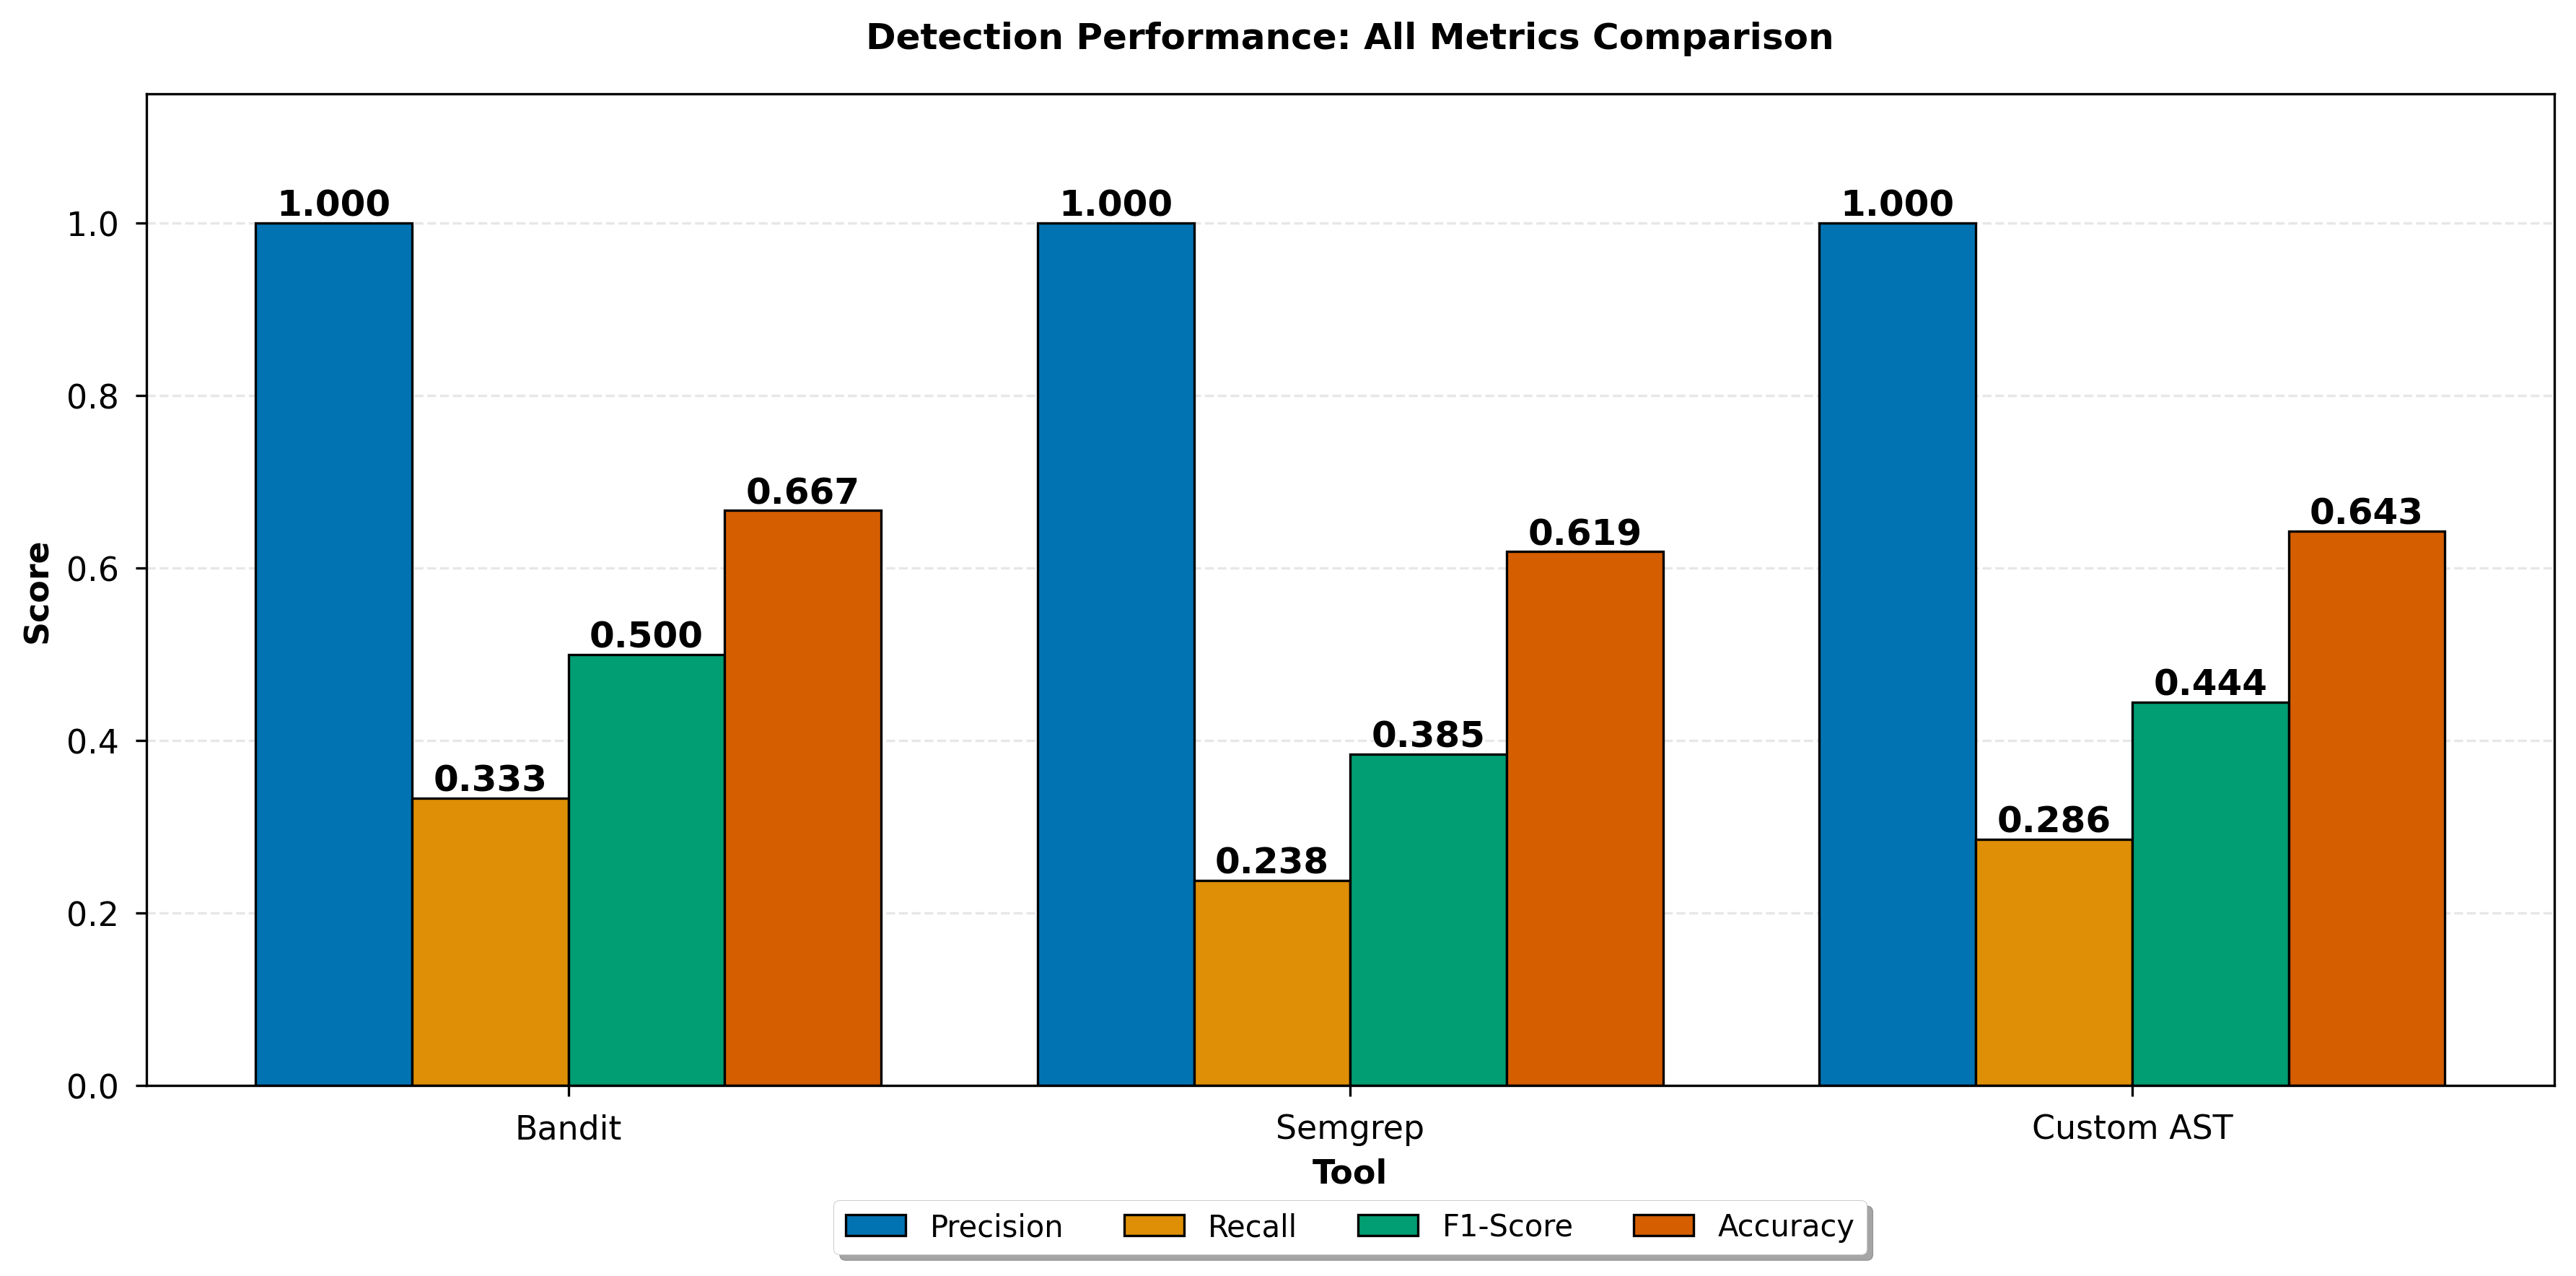

✓ All metrics comparison plot saved


In [11]:
# Plot 2: Grouped Bar Chart for All Metrics
fig, ax = plt.subplots(figsize=(12, 6))

metrics_to_plot = ['Precision', 'Recall', 'F1-Score', 'Accuracy']
x = np.arange(len(tools))
width = 0.2

# Create display labels with "Custom AST" instead of "ast"
tools_display_labels = ['Bandit' if t == 'bandit' else 'Semgrep' if t == 'semgrep' else 'Custom AST' for t in tools]

bar_containers = []
for i, metric in enumerate(metrics_to_plot):
    offset = width * (i - 1.5)
    values = [metrics_df.loc[tool, metric] for tool in tools]
    bars = ax.bar(x + offset, values, width, label=metric, edgecolor='black', linewidth=0.8)
    bar_containers.append(bars)
    
    # Add value labels on each bar
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_xlabel('Tool', fontsize=11, fontweight='bold')
ax.set_ylabel('Score', fontsize=11, fontweight='bold')
ax.set_title('Detection Performance: All Metrics Comparison', fontsize=12, fontweight='bold', pad=15)
ax.set_xticks(x)
ax.set_xticklabels(tools_display_labels, fontsize=11)
ax.tick_params(axis='y', labelsize=11)
ax.set_ylim([0, 1.15])  # Increased to make room for labels
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4, frameon=True, shadow=True)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig('data/rq2_all_metrics_comparison.png', bbox_inches='tight')
plt.show()

print("✓ All metrics comparison plot saved")


In [12]:
print("\n" + "="*70)
print("RQ2 DETECTION METRICS ANALYSIS - COMPLETE")
print("="*70)
print("\nKey Findings:")
print(f"  • Best F1-Score: {metrics_df['F1-Score'].idxmax()} ({metrics_df['F1-Score'].max():.3f})")
print(f"  • Best Precision: {metrics_df['Precision'].idxmax()} ({metrics_df['Precision'].max():.3f})")
print(f"  • Best Recall: {metrics_df['Recall'].idxmax()} ({metrics_df['Recall'].max():.3f})")
print(f"  • Best Accuracy: {metrics_df['Accuracy'].idxmax()} ({metrics_df['Accuracy'].max():.3f})")

print("\nOutputs Generated:")
print("  • rq2_all_metrics_comparison.png")
print("  • Stratified confusion matrix results by dataset type (printed above)")
print("="*70)


RQ2 DETECTION METRICS ANALYSIS - COMPLETE

Key Findings:
  • Best F1-Score: bandit (0.500)
  • Best Precision: bandit (1.000)
  • Best Recall: bandit (0.333)
  • Best Accuracy: bandit (0.667)

Outputs Generated:
  • rq2_all_metrics_comparison.png
  • Stratified confusion matrix results by dataset type (printed above)
